In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#from mpl_toolkits.basemap import Basemap
import scipy.stats as ss
import scipy.signal as ssi

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [2]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [2]:
def sdat(c, F):
        #My old fashioned way of saving data
        np.savez(F, u=c)
        return 0
    
def lin_regression(var1, var2):
	"""
	Regresses var1 onto var2
	Returns: slope, intercept, r_value, p_value, std_err
	"""
	#print "Linear regression"
	return ss.linregress(var1, var2)

def seasonal_cycle( data ):
    
    d1 = len(data)
    
    seas = np.zeros( 12)
    a = 1
    for i in range( d1):
        seas[i%12] += data[i]
        if i > 0 and i %12 == 0:
            a += 1

    seas /= float( a)
    return seas

def annual_mean(data):
    
    d1 = len(data)
    ndata = np.zeros( d1 // 12)
    for i in range( d1 // 12):
        ndata[i] = np.mean(data[i * 12:(i + 1) * 12])
        
    return ndata

def deasonalize(data):
    
    d1 = len(data)
    ndata = np.zeros( d1)
    seasonal_cycle = np.zeros( 12 )
    a = 0
    for i in range( d1 ):
        seasonal_cycle[i % 12] += data[i]
        if i > 0 and i %12 ==0:
            a += 1
    seasonal_cycle /= float(a)
    for i in range( d1 ):
        ndata[i] = data[i] - seasonal_cycle[i % 12] 
        
    return ndata

In [3]:
#List of models for which data is available:
model = ["CanESM5", "CESM2", "CNRM-CM6-1", "MRI-ESM2-0", "CNRM-ESM2-1", "IPSL-CM6A-LR",
         "UKESM1-0-LL", "CESM2-WACCM", "GFDL-CM4", "MIROC-ES2L", "HadGEM3-GC31-LL", "GISS-E2-1-H", 
         "GFDL-ESM4", "GISS-E2-1-G", "BCC-CSM2-MR", "BCC-ESM1", "INM-CM4-8", "NorESM2-LM", "MPI-ESM1-2-HR",
         "MIROC6", "FGOALS-f3-L", "NESM3", "SAM0-UNICON", "EC-Earth3-Veg"]
m = len( model )

In [4]:
#Latitude limits:
lim1 = [-90, -60, -30, 30, 60]
lim2 = [-60, -30, 30, 60, 90]
dl = 17 #years of data
d = 21
dif_CRE = np.zeros( ( 5, d))
dcre_dt_m = np.zeros( ( (5, 3, d)))
dcre_dt_m_c = np.zeros( ( (5, 3, d)))
dcre_dt_a = np.zeros( ( (5, 3, d)))
dcre_dt_a_c = np.zeros( ( ( 5, 3, d)))

opts = ['rlut', 'rsut', 'rlutcs', 'rsutcs']


for k in range( 5 ):
    monthly_cre = np.zeros( ( (m, 3, dl * 12)))
    monthly_t = np.zeros( ( (m, 3, dl * 12)))

    for i in range( d ):
        histt = np.load("data/" + model[i] + "_historical_tas_" + str(lim1[k]) + "_" + str(lim2[k]) + ".dat.npz")
        hist_t = histt["u"]

        abruptt = np.load("data/" + model[i] + "_abrupt-4xCO2_tas_" + str(lim1[k]) + "_" + str(lim2[k]) + ".dat.npz")
        abrupt_t = abruptt["u"]
        pit = np.load("data/" + model[i] + "_PI_tas_" + str(lim1[k]) + "_" + str(lim2[k]) + ".dat.npz")
        pi_t = pit["u"]
        d1, d2 = np.shape( hist_t)
        hist_c = np.zeros( (d1, d2))
        for j in range( 4 ):
            temp = np.load("data/" + model[i] + "_historical_" + opts[j] + 
                           "_" + str(lim1[k]) + "_" + str(lim2[k]) + ".dat.npz")
            if j< 2:
                hist_c += temp["u"][:]
            else:
                hist_c -= temp["u"][:]
                
            for h in range( 3 ):
                monthly_cre[i, h] = np.mean(hist_c[114 * 12 + h * dl * 12:131 * 12 + h * dl * 12], axis = 1) 
                monthly_t[i, h] = np.mean(hist_t[114 * 12 + h * dl * 12:131 * 12 + h * dl * 12], axis = 1) 
                monthly_t[i, h] = deasonalize(monthly_t[i, h])
                monthly_cre[i, h] = deasonalize(monthly_cre[i, h])
                dcre_dt_m[k, h, i] = lin_regression( monthly_t[i, h], monthly_cre[i, h])[0]
                dcre_dt_m_c[k, h, i] = lin_regression( monthly_t[i, h], monthly_cre[i, h])[4]*1.96

                annual_t = annual_mean(monthly_t[i, h])
                annual_cre = annual_mean(monthly_cre[i, h])
                annual_cre = ssi.detrend(annual_cre)
                annual_t = ssi.detrend(annual_t)
                dcre_dt_a[k, h, i] = lin_regression( annual_t, annual_cre)[0]
                dcre_dt_a_c[k, h, i] = lin_regression( annual_t, annual_cre)[4]* 1.96

        for j in range( 4 ):
            temp2 = np.load("data/" + model[i] + "_abrupt-4xCO2_" + opts[j] + 
                           "_" +  str(lim1[k]) + "_" + str(lim2[k]) + ".dat.npz")
            d1, d2 = np.shape( temp2["u"])
            if j == 0:
                abrupt_cre = np.zeros( ( d1, d2))
            if j < 2:
                abrupt_cre += temp2["u"][:]
            else:
                abrupt_cre -= temp2["u"][:]
            temp3 = np.load("data/" + model[i] + "_PI_" + opts[j] + 
                           "_" +  str(lim1[k]) + "_" + str(lim2[k]) + ".dat.npz")
            d1, d2 = np.shape( temp3["u"])
            if i == 6:
                d1 = 6000
            if j == 0:
                pi_cre = np.zeros( ( d1, d2))
            if j < 2:
                pi_cre += temp3["u"][:d1]
            else:
                pi_cre -= temp3["u"][:d1]
            del_cre = np.mean(abrupt_cre[:] - np.mean( pi_cre[:500 * 12]), axis = 1)
            del_t = np.mean(abrupt_t[:] - np.mean( pi_t[:500 * 12]), axis = 1)

            del_cre = annual_mean(del_cre)
            del_t = annual_mean( del_t)

            dif_CRE[k, i] = lin_regression(del_t[:], del_cre[:])[0]


In [5]:
#Once the list of files has been pulled up, download files[lev:lev2]
alev = [2, 4, 6, 0, 0, 3, 0, 4, 3, 0, 2, 3, 0, 6, 0, 0, 2, 50, 33, 0]
alev2 = [3, 5, 7, 1, 1, 4, 2, 7, 6, 1, 4, 6, 2, 9, 1, 1, 4, 65, 66, 2 ]
alev3 = [4, 4, 6, 0, 0, 11, 0, 4, 3, 0, 2, 3, 0, 6, 0, 0, 2, 50, 33, 0]
alev4 = [5, 5, 7, 1, 1, 12, 2, 7, 6, 1, 4, 6, 2, 9, 1, 1, 4, 65, 66, 2]
alev5 = [4, 4, 6, 0, 0, 3, 0, 4, 3, 0, 2, 3, 0, 6, 0, 0, 2, 50, 33, 0]
alev6 = [5, 5, 7, 1, 1, 4, 2, 7, 6, 1, 4, 6, 2, 9, 1, 1, 4, 65, 66, 2]
alev7 = [4, 4, 6, 0, 0, 3, 0, 4, 3, 0, 2, 3, 0, 6, 0, 0, 15, 50, 33, 14]
alev8 = [5, 5, 7, 4, 1, 4, 2, 7, 6, 1, 4, 6, 2, 9, 4, 1, 30, 65, 66, 30]

In [6]:
#For checking availability and format of data
d = 19
ids = ['tas', 'rlut', 'rsut', 'rlutcs', 'rsutcs', 'wap']
for i in range(4, 6):
    result3 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                          variable_id=ids[i], experiment_id='abrupt-4xCO2')
    if i < 5:
        print(result3[alev5[d]:alev6[d]])
        files_to_open = result3[alev5[d]:alev6[d]]
    else:
        print(result3[alev7[d]:alev8[d]])
        files_to_open = result3[alev7[d]:alev8[d]]
    ds = xr.open_mfdataset(files_to_open)

https://esgf1.dkrz.d/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MIROC6&variable_id=rsutcs&experiment_id=abrupt-4xCO2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0


ConnectionError: HTTPSConnectionPool(host='esgf1.dkrz.d', port=443): Max retries exceeded with url: /esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MIROC6&variable_id=rsutcs&experiment_id=abrupt-4xCO2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fbe182e16d0>: Failed to establish a new connection: [Errno -2] Name or service not known'))

In [121]:
#Download data
bins = np.arange(-100., 105., 5.)
b = len(bins)

for d in range( 19, 22 ):
    print("Doing: ", model[d])

    result1 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='tas', experiment_id='abrupt-4xCO2')
    result2 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='rlut', experiment_id='abrupt-4xCO2')
    result3 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='rsut', experiment_id='abrupt-4xCO2')
    result4 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='rlutcs', experiment_id='abrupt-4xCO2')
    result5 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='rsutcs', experiment_id='abrupt-4xCO2')
    result6 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='wap', experiment_id='abrupt-4xCO2')
                
    files_to_open = result1[alev[d]:alev2[d]]
    files_to_open2 = result2[alev3[d]:alev4[d]]
    files_to_open3 = result3[alev5[d]:alev6[d]]
    files_to_open4 = result4[alev5[d]:alev6[d]]
    files_to_open5 = result5[alev5[d]:alev6[d]]
    files_to_open6 = result6[alev7[d]:alev8[d]]

    ds = xr.open_mfdataset(files_to_open)
    ds2 = xr.open_mfdataset(files_to_open2)
    ds3 = xr.open_mfdataset(files_to_open3)
    ds4 = xr.open_mfdataset(files_to_open4)
    ds5 = xr.open_mfdataset(files_to_open5)
    ds6 = xr.open_mfdataset(files_to_open6)

    wap = ds6.wap.sel(plev="50000")
    cre = ds2.rlut + ds3.rsut -ds4.rlutcs - ds5.rsutcs
    wap = wap.sel(lat=slice(-30., 30.))
    cre = cre.sel(lat=slice(-30., 30.))
    tas = ds.tas.sel(lat=slice(-30., 30.))
    
    wap = np.array(wap)
    d1, d2, d3 = np.shape(wap)
    wap = np.reshape( wap, ( (d1, d2 * d3)))
    cre = np.array(cre)
    cre = np.reshape( cre, ( (d1, d2 * d3)))
    tas = np.array(tas)
    tas = np.reshape( tas, ( (d1, d2 * d3)))

    new_data = np.zeros( ( ( 3, d1, d2 * d3)))
    new_data[0] = wap[:, :] * 864.
    new_data[1] = cre[:, :]
    new_data[2] = tas[:, :]
    
    binned_data = np.zeros( ( 2, d1, b - 1))
    for i in range( d1):
        if i % 100 == 0:
            print(i)
        for k in range( b - 1):
            binned_data[0, i, k] = np.mean(new_data[1, i, (new_data[0, i] >bins[k]) & (new_data[0, i] < bins[k + 1])])
            binned_data[1, i, k] = np.mean(new_data[2, i, (new_data[0, i] >bins[k]) & (new_data[0, i] < bins[k + 1])])

    sdat(binned_data, "data/binned_" + model[d] + "_4XCO2_data.dat")

Doing:  MIROC6
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MIROC6&variable_id=tas&experiment_id=abrupt-4xCO2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MIROC6&variable_id=rlut&experiment_id=abrupt-4xCO2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MIROC6&variable_id=rsut&experiment_id=abrupt-4xCO2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MIROC6&variable_id=rlutcs&experiment_id=abrupt-4xCO2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MIROC6&variable_id=rsutcs

/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda

0


/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
Doing:  FGOALS-f3-L
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=FGOALS-f3-L&variable_id=tas&experiment_id=abrupt-4xCO2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=FGOALS-f3-L&variable_id=rlut&experiment_id=abrupt-4xCO2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=FGOALS-f3-L&variable_id=rsut&experiment_id=abrupt-4xCO2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=FGOALS-f3-L&variable_id=rlutcs&experiment_id=abrupt-4xCO2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esg

IndexError: list index out of range

In [162]:
#Once the list of files has been pulled up, download files[lev:lev2]
lev = [5, 12, 0, 2, 0, 0, 8, 7, 5, 3, 0, 14, 5, 36, 0, 0, 7, 0, 100, 8]
lev2 = [8, 24, 1, 3, 1, 1, 14, 14, 10, 6, 10, 20, 10, 46, 1, 1, 9, 50, 200, 13]
lev3 = [5, 12, 0, 2, 0, 0, 8, 7, 5, 3, 0, 14, 5, 36, 0, 0, 0, 20, 100, 8]
lev4 = [8, 24, 1, 15, 1, 1, 14, 14, 10, 6, 10, 20, 10, 46, 15, 2, 40, 50, 200, 13]

In [165]:
#For checking availability and format of data
d = 17
ids = ['tas', 'rlut', 'rsut', 'rlutcs', 'rsutcs', 'wap']
for i in range(4, 6):
    #255012
    result3 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                          variable_id=ids[i], experiment_id='piControl')
    if i < 5:
        print(result3[lev[d]:lev2[d]])
        files_to_open = result3[lev[d]:lev2[d]]        
    else:
        print(result3[lev3[d]:lev4[d]])
        files_to_open = result3[lev3[d]:lev4[d]] 
    ds = xr.open_mfdataset(files_to_open)

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NorESM2-LM&variable_id=rsutcs&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NorESM2-LM&variable_id=rsutcs&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NorESM2-LM&variable_id=rsutcs&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NorESM2-LM&variable_id=rsutcs&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NorESM2-LM&variable_id=rsu

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NorESM2-LM&variable_id=wap&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NorESM2-LM&variable_id=wap&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NorESM2-LM&variable_id=wap&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NorESM2-LM&variable_id=wap&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NorESM2-LM&variable_id=wap&experiment_

In [168]:
#Download data
bins = np.arange(-100., 105., 5.)
b = len(bins)

for d in range( 17, 22 ):
    print("Doing: ", model[d])

    result1 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='tas', experiment_id='piControl')
    result2 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='rlut', experiment_id='piControl')
    result3 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='rsut', experiment_id='piControl')
    result4 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='rlutcs', experiment_id='piControl')
    result5 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='rsutcs', experiment_id='piControl')
    result6 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='wap', experiment_id='piControl')
                
    if lev2[d] - lev[d] > 1:
        files_to_open = result1[lev[d]:lev2[d]]
        files_to_open2 = result2[lev[d]:lev2[d]]
        files_to_open3 = result3[lev[d]:lev2[d]]
        files_to_open4 = result4[lev[d]:lev2[d]]
        files_to_open5 = result5[lev[d]:lev2[d]]
        files_to_open6 = result6[lev3[d]:lev4[d]]

        ds = xr.open_mfdataset(files_to_open)
        ds2 = xr.open_mfdataset(files_to_open2)
        ds3 = xr.open_mfdataset(files_to_open3)
        ds4 = xr.open_mfdataset(files_to_open4)
        ds5 = xr.open_mfdataset(files_to_open5)
        ds6 = xr.open_mfdataset(files_to_open6)

    else:
        files_to_open = result1[lev[d]]
        files_to_open2 = result2[lev[d]]
        files_to_open3 = result3[lev[d]]
        files_to_open4 = result4[lev[d]]
        files_to_open5 = result5[lev[d]]

        ds = xr.open_dataset(files_to_open, chunks={'time': '100MB'}, decode_times=False)
        ds2 = xr.open_dataset(files_to_open2, chunks={'time': '100MB'}, decode_times=False)
        ds3 = xr.open_dataset(files_to_open3, chunks={'time': '100MB'}, decode_times=False)
        ds4 = xr.open_dataset(files_to_open4, chunks={'time': '100MB'}, decode_times=False)
        ds5 = xr.open_dataset(files_to_open5, chunks={'time': '100MB'}, decode_times=False)
        if d == 3 or d == 14 or d == 15:
            files_to_open6 = result6[lev3[d]:lev4[d]]
            ds6 = xr.open_mfdataset(files_to_open6)#, chunks={'time': '100MB'}, decode_times=False)
        else:
            files_to_open6 = result6[lev3[d]]
            ds6 = xr.open_dataset(files_to_open6, chunks={'time': '100MB'}, decode_times=False)
            
            
    wap = ds6.wap.sel(plev="50000")
    cre = ds2.rlut + ds3.rsut -ds4.rlutcs - ds5.rsutcs
    wap = wap.sel(lat=slice(-30., 30.))
    cre = cre.sel(lat=slice(-30., 30.))
    tas = ds.tas.sel(lat=slice(-30., 30.))
    
    wap = np.array(wap)
    d1, d2, d3 = np.shape(wap)

    wap = np.reshape( wap, ( (d1, d2 * d3)))
    cre = np.array(cre)
    tas = np.array(tas)

    print(np.shape(wap), np.shape(cre))
    if d == 0:
        tas = np.reshape( tas[149 * 12:, :, :], ( (d1, d2 * d3)))
        cre = np.reshape( cre[:, :, :], ( (d1, d2 * d3)))
    elif d == 2 or d == 4:
        cre = np.reshape( cre[:3000], ( (d1, d2 * d3)))
        tas = np.reshape( tas[:3000], ( (d1, d2 * d3)))
    elif d == 3:
        cre = np.reshape( cre[1200:], ( (d1, d2 * d3)))
        tas = np.reshape( tas[1200:], ( (d1, d2 * d3)))
    elif d == 17:
        cre = np.reshape( cre[200 * 12:], ( (d1, d2 * d3)))
        tas = np.reshape( tas[200 * 12:], ( (d1, d2 * d3)))
    else:
        cre = np.reshape( cre, ( (d1, d2 * d3)))
        tas = np.reshape( tas, ( (d1, d2 * d3)))  
        
    new_data = np.zeros( ( ( 3, d1, d2 * d3)))
    new_data[0] = wap[:, :] * 864.
    new_data[1] = cre[:, :]
    new_data[2] = tas[:, :]
    
    binned_data = np.zeros( ( 2, d1, b - 1))
    for i in range( d1):
        if i % 100 == 0:
            print(i)
        for k in range( b - 1):
            binned_data[0, i, k] = np.mean(new_data[1, i, (new_data[0, i] >bins[k]) & (new_data[0, i] < bins[k + 1])])
            binned_data[1, i, k] = np.mean(new_data[2, i, (new_data[0, i] >bins[k]) & (new_data[0, i] < bins[k + 1])])

    seas_binned = np.zeros( ( (2, b - 1, 12)))
    for i in range( b - 1):
        seas_binned[0, i] = seasonal_cycle(binned_data[0, :, i])
        seas_binned[1, i] = seasonal_cycle(binned_data[1, :, i])

    sdat(seas_binned, "data/seas_binned_" + model[d] + "_piControl_data.dat")

Doing:  NorESM2-LM
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NorESM2-LM&variable_id=tas&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NorESM2-LM&variable_id=tas&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NorESM2-LM&variable_id=tas&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NorESM2-LM&variable_id=tas&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NorESM2-LM&variable

/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
Doing:  MPI-ESM1-2-HR
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MPI-ESM1-2-HR&variable_id=tas&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MPI-ESM1-2-HR&variable_id=tas&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MPI-ESM1-2-HR&variable_id=tas&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MPI-ESM1-2-HR&variable_id=tas&experiment_id=piControl&project=CMI

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MPI-ESM1-2-HR&variable_id=rsut&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MPI-ESM1-2-HR&variable_id=rsut&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MPI-ESM1-2-HR&variable_id=rsut&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MPI-ESM1-2-HR&variable_id=rsut&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=40
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MPI-ESM1-2-HR&variabl

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MPI-ESM1-2-HR&variable_id=rsutcs&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MPI-ESM1-2-HR&variable_id=rsutcs&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=40
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MPI-ESM1-2-HR&variable_id=rsutcs&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=50
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MPI-ESM1-2-HR&variable_id=rsutcs&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=60
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MPI-ESM1-2-HR

/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/Anaconda

/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/Anaconda

/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/Anaconda

/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/Anaconda

/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/Anaconda

/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/Anaconda

/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/Anaconda

/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/Anaconda

/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/Anaconda

/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/Anaconda

/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/Anaconda

/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/Anaconda

(6000, 24576) (6000, 64, 384)
0


/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
Doing:  MIROC6
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MIROC6&variable_id=tas&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MIROC6&variable_id=tas&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=MIROC6&variable_id=rlut&experiment_id=piControl&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_

/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/Anaconda

(600, 10752) (6000, 42, 256)


ValueError: cannot reshape array of size 64512000 into shape (600,10752)

In [81]:
#Once the list of files has been pulled up, download files[lev:lev2]
hlev = [40, 40, 29, 6, 0, 0, 2, 0, 3, 0, 0, 80, 0, 80, 0, 0, 3, 34, 33 * 10, 2, 17, 0]
hlev2 = [41, 44, 30, 7, 1, 1, 4, 1, 5, 1, 2, 84, 2, 84, 1, 1, 6, 51, 33 * 11, 4, 34, 1]

hlev3 = [40, 40, 29, 0, 0, 0, 2, 0, 3, 0, 0, 80, 0, 80, 0, 0, 17, 34, 33 * 10, 68, 17, 0]
hlev4 = [41, 44, 30, 4, 1, 1, 4, 1, 5, 1, 2, 84, 2, 84, 5, 1, 34, 51, 33 * 11, 85, 34, 1]

In [86]:
#For checking availability and format of data
d = 21
ids = ['tas', 'rlut', 'rsut', 'rlutcs', 'rsutcs', 'wap']
for i in range(4, 6):
    #255012
    result3 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                          variable_id=ids[i], experiment_id='historical')
    if i < 5:
        print(result3[hlev[d]:hlev2[d]])
        files_to_open = result3[hlev[d]:hlev2[d]]        
    else:
        print(result3[hlev3[d]:hlev4[d]])
        files_to_open = result3[hlev3[d]:hlev4[d]]
    ds = xr.open_mfdataset(files_to_open)

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NESM3&variable_id=rsutcs&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NESM3&variable_id=rsutcs&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
['http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/rsutcs/gn/v20190630/rsutcs_Amon_NESM3_historical_r1i1p1f1_gn_185001-201412.nc']
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NESM3&variable_id=wap&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NESM3&variable_id=wap&experiment_id=historical&project=CMIP6&type=File&distrib=false&fo

In [87]:
#Download data
bins = np.arange(-100., 105., 5.)
b = len(bins)

for d in range( 21, 22 ):
    print("Doing: ", model[d])

    result1 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='tas', experiment_id='historical')
    result2 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='rlut', experiment_id='historical')
    result3 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='rsut', experiment_id='historical')
    result4 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='rlutcs', experiment_id='historical')
    result5 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='rsutcs', experiment_id='historical')
    result6 = esgf_search(activity_id='CMIP', table_id='Amon', source_id=model[d], 
                              variable_id='wap', experiment_id='historical')
                
    files_to_open = result1[hlev[d]:hlev2[d]]
    files_to_open2 = result2[hlev[d]:hlev2[d]]
    files_to_open3 = result3[hlev[d]:hlev2[d]]
    files_to_open4 = result4[hlev[d]:hlev2[d]]
    files_to_open5 = result5[hlev[d]:hlev2[d]]
    files_to_open6 = result6[hlev3[d]:hlev4[d]]

    ds = xr.open_mfdataset(files_to_open)
    ds2 = xr.open_mfdataset(files_to_open2)
    ds3 = xr.open_mfdataset(files_to_open3)
    ds4 = xr.open_mfdataset(files_to_open4)
    ds5 = xr.open_mfdataset(files_to_open5)
    ds6 = xr.open_mfdataset(files_to_open6)

    wap = ds6.wap.sel(plev="50000")
    cre = ds2.rlut + ds3.rsut -ds4.rlutcs - ds5.rsutcs
    wap = wap.sel(lat=slice(-30., 30.))
    cre = cre.sel(lat=slice(-30., 30.))
    tas = ds.tas.sel(lat=slice(-30., 30.))
    
    wap = np.array(wap)
    d1, d2, d3 = np.shape(wap)
    wap = np.reshape( wap, ( (d1, d2 * d3)))
    cre = np.array(cre)
    cre = np.reshape( cre, ( (d1, d2 * d3)))
    tas = np.array(tas)
    tas = np.reshape( tas, ( (d1, d2 * d3)))

    new_data = np.zeros( ( ( 3, d1, d2 * d3)))
    new_data[0] = wap[:, :] * 864.
    new_data[1] = cre[:, :]
    new_data[2] = tas[:, :]
    
    binned_data = np.zeros( ( 2, d1, b - 1))
    for i in range( d1):
        if i % 100 == 0:
            print(i)
        for k in range( b - 1):
            binned_data[0, i, k] = np.mean(new_data[1, i, (new_data[0, i] >bins[k]) & (new_data[0, i] < bins[k + 1])])
            binned_data[1, i, k] = np.mean(new_data[2, i, (new_data[0, i] >bins[k]) & (new_data[0, i] < bins[k + 1])])

    sdat(binned_data, "data/binned_" + model[d] + "_historical_data.dat")

Doing:  NESM3
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NESM3&variable_id=tas&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NESM3&variable_id=tas&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NESM3&variable_id=rlut&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NESM3&variable_id=rlut&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&source_id=NESM3&variable_id=rsut&experiment_id=hi

/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/Anaconda3-2020.07-Linux-x86_64/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


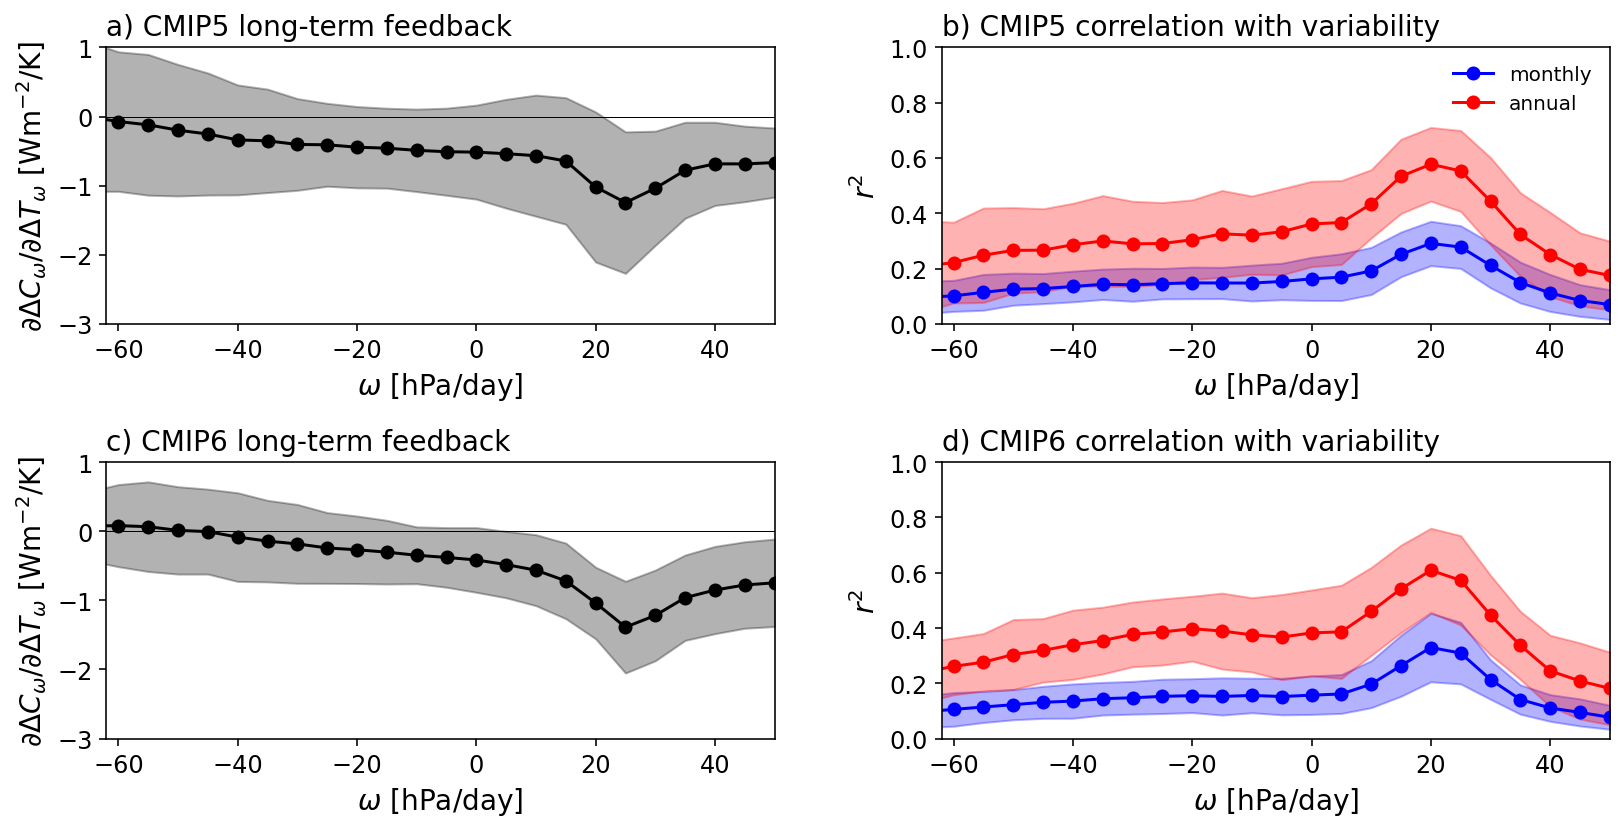

In [5]:
#Download data
bins = np.arange(-100., 105., 5.)
b = len(bins)

dd = 14
binned_regr = np.zeros( ( dd, b - 1))
forced = np.zeros( dd)
a = 0
corr = np.zeros( b - 1 )
for d in 0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15:

    binned_data = np.load("data/binned_" + model[d] + "_4XCO2_data.dat.npz")
    seas_binned_data = np.load("data/seas_binned_" + model[d] + "_piControl_data.dat.npz")

    binned = binned_data['u'][:]
    seas_binned = seas_binned_data['u'][:]

    d1, d2, d3 = np.shape( binned)
    for i in range( d2):
        binned[0, i, :] -= seas_binned[0, :, i%12]
        binned[1, i, :] -= seas_binned[1, :, i%12]
        
    for i in range( b - 1):
        binned_regr[a, i] = lin_regression(binned[1, :, i], 
                                        binned[0, :, i])[0]
    forced[a] = dif_CRE[2, d]
    a += 1 
for i in range( b - 1):
    corr[i] = np.corrcoef( binned_regr[:, i], forced)[0, 1] ** 2
    
       
fig = plt.figure( figsize = (12, 6))
plt.subplots_adjust(left = 0.1, right = 0.97, bottom = 0.15, top = 0.95, hspace = 0.5, wspace = 0.25)

ax = plt.subplot(2, 2, 3)
plt.title("c) CMIP6 long-term feedback", fontsize = 14, loc = "left")

plt.plot( bins[:b-1], np.mean(binned_regr, axis = 0), 'ko-')
ax.fill_between(bins[:b-1], np.mean(binned_regr, axis = 0) - np.std(binned_regr, axis = 0),
                np.mean(binned_regr, axis = 0) + np.std(binned_regr, axis = 0), color = 'k', alpha = 0.3)

plt.axhline( y = 0, color = 'k', linewidth = 0.5)
plt.ylim([-3., 1.])
plt.xlim([-62., 50.])

plt.xlabel("$\omega$ [hPa/day]", fontsize = 14)
plt.ylabel("$\partial\Delta C_\omega / \partial\Delta T_\omega$ [Wm$^{-2}$/K]", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


dd = 18
corrs = np.zeros( ( ( dd, 2, b - 1)) )
for d in range(dd):

    binned_data = np.load("data/binned_" + model[d] + "_historical_data.dat.npz")
    binned_data = binned_data['u'][:]
    d1, d2, d3 = np.shape( binned_data)

    an_binned_data = np.zeros( ( ( d1, d2 // 12, d3)))
    for i in range( d1):
        for j in range( d3):
            an_binned_data[i, :, j] = annual_mean(binned_data[i, :, j])
    
    seas_binned = np.zeros( ( (2, b - 1, 12)))
    for i in range( b - 1):
        seas_binned[0, i] = seasonal_cycle(binned_data[0, :, i])
        seas_binned[1, i] = seasonal_cycle(binned_data[1, :, i])
    for i in range( d2):
        binned_data[0, i, :] -= seas_binned[0, :, i%12]
        binned_data[1, i, :] -= seas_binned[1, :, i%12]   
    
    zrlut = np.load("data/" + model[d] + "_historical_rlut_-30_30.dat.npz")
    zrsut = np.load("data/" + model[d] + "_historical_rsut_-30_30.dat.npz")
    zrlutcs = np.load("data/" + model[d] + "_historical_rlutcs_-30_30.dat.npz")
    zrsutcs = np.load("data/" + model[d] + "_historical_rsutcs_-30_30.dat.npz")

    mon_var =  zrlut['u'][:] + zrsut['u'][:] - zrlutcs['u'][:] - zrsutcs['u'][:]
    mon_var = np.mean(mon_var, axis = 1)
    an_var =  annual_mean(mon_var)
    seas_var = seasonal_cycle(mon_var)
    for i in range( d2):
        mon_var[i] -= seas_var[i%12]

    for i in range( b - 1):
        corrs[d, 0, i] = np.corrcoef( mon_var, binned_data[0, :, i])[0, 1] ** 2
        corrs[d, 1, i] = np.corrcoef( an_var, an_binned_data[0, :, i])[0, 1] ** 2
    
ax = plt.subplot(2, 2, 4)
plt.title("d) CMIP6 correlation with variability", fontsize = 14, loc = "left")

plt.plot( bins[:b-1], np.mean(corrs[:, 0], axis = 0), 'bo-')
plt.plot( bins[:b-1], np.mean(corrs[:, 1], axis = 0), 'ro-')
#plt.legend(["monthly", "annual"], frameon = False)

ax.fill_between(bins[:b-1], np.mean(corrs[:, 0], axis = 0) - np.std(corrs[:, 0], axis = 0),
                np.mean(corrs[:, 0], axis = 0) + np.std(corrs[:, 0], axis = 0), color = 'b', alpha = 0.3)
ax.fill_between(bins[:b-1], np.mean(corrs[:, 1], axis = 0) - np.std(corrs[:, 1], axis = 0),
                np.mean(corrs[:, 1], axis = 0) + np.std(corrs[:, 1], axis = 0), color = 'r', alpha = 0.3)

plt.axhline( y = 0, color = 'k', linewidth = 0.5)
plt.ylim([0., 1.])
plt.xlim([-62., 50.])

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.xlabel("$\omega$ [hPa/day]", fontsize = 14)
plt.ylabel("$r^2$", fontsize = 14)

#CMIP5 data taken from GFDL
models = ["BNU-ESM", "CanESM2", "CSIRO-Mk3-6-0", "CCSM4", "CNRM-CM5", 
          "GFDL-CM3", "GFDL-ESM2G", "GFDL-ESM2M", "GISS-E2-H", "HadGEM2-ES", "IPSL-CM5B-LR", 
          "GISS-E2-R", "INM-CM4", "IPSL-CM5A-LR", "IPSL-CM5A-MR", "MIROC5", "MIROC-ESM", 
          "MPI-ESM-LR", "MPI-ESM-MR", "MPI-ESM-P", "MRI-CGCM3", "NorESM1-M"]


m = len(models)

#Download data
bins = np.arange(-100., 105., 5.)
b = len(bins)

dd = m
binned_regr = np.zeros( ( dd, b - 1))
forced = np.zeros( dd)
a = 0
corr = np.zeros( b - 1 )

for d in range(dd):

    binned_data = np.load("data/binned_" + models[d] + "_4XCO2_data.dat.npz")
    seas_binned_data = np.load("data/seas_binned_" + models[d] + "_piControl_data.dat.npz")

    binned = binned_data['u'][:]
    seas_binned = seas_binned_data['u'][:]
    #print(seas_binned[0, :, 10])

    d1, d2, d3 = np.shape( binned)
    for i in range( d2):
        binned[0, i, :] -= seas_binned[0, :, i%12]
        binned[1, i, :] -= seas_binned[1, :, i%12]
        
    for i in range( b - 1):
        binned_regr[a, i] = lin_regression(binned[1, :, i], 
                                        binned[0, :, i])[0]
                                        
    #dif_CRE = np.load("data/" + models[d] + "_tropical_CRE_feedback.dat.npz")
    #forced[a] = dif_CRE["u"]
    a += 1 
    
for i in range( b - 1):
    corr[i] = np.corrcoef( binned_regr[:, i], forced)[0, 1] ** 2
    
ax = plt.subplot(2,2, 1)
plt.title("a) CMIP5 long-term feedback", fontsize = 14, loc = "left")

plt.plot( bins[:b-1], np.mean(binned_regr, axis = 0), 'ko-')
ax.fill_between(bins[:b-1], np.mean(binned_regr, axis = 0) - np.std(binned_regr, axis = 0),
                np.mean(binned_regr, axis = 0) + np.std(binned_regr, axis = 0), color = 'k', alpha = 0.3)

plt.axhline( y = 0, color = 'k', linewidth = 0.5)
plt.ylim([-3., 1.])
plt.xlim([-62., 50.])

plt.xlabel("$\omega$ [hPa/day]", fontsize = 14)
plt.ylabel("$\partial\Delta C_\omega / \partial\Delta T_\omega$ [Wm$^{-2}$/K]", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


corrs = np.zeros( ( ( dd, 2, b - 1)) )
for d in range(dd):

    binned_data = np.load("data/binned_" + models[d] + "_historical_data.dat.npz")
    binned_data = binned_data['u'][:]
    d1, d2, d3 = np.shape( binned_data)

    an_binned_data = np.zeros( ( ( d1, d2 // 12, d3)))
    for i in range( d1):
        for j in range( d3):
            an_binned_data[i, :, j] = annual_mean(binned_data[i, :, j])
    
    seas_binned = np.zeros( ( (2, b - 1, 12)))
    for i in range( b - 1):
        seas_binned[0, i] = seasonal_cycle(binned_data[0, :, i])
        seas_binned[1, i] = seasonal_cycle(binned_data[1, :, i])
    for i in range( d2):
        binned_data[0, i, :] -= seas_binned[0, :, i%12]
        binned_data[1, i, :] -= seas_binned[1, :, i%12]   
    
    zcre = np.load("data/" + models[d] + "_historical_cre_-30_30.dat.npz")
    mon_var =  zcre['u'][:] 
    mon_var = np.mean(mon_var, axis = 1)
    an_var =  annual_mean(mon_var)
    seas_var = seasonal_cycle(mon_var)
    for i in range( d2):
        mon_var[i] -= seas_var[i%12]

    for i in range( b - 1):
        corrs[d, 0, i] = np.corrcoef( mon_var, binned_data[0, :, i])[0, 1] ** 2
        corrs[d, 1, i] = np.corrcoef( an_var, an_binned_data[0, :, i])[0, 1] ** 2
    
ax = plt.subplot(2, 2, 2)
plt.title("b) CMIP5 correlation with variability", fontsize = 14, loc = "left")

plt.plot( bins[:b-1], np.mean(corrs[:, 0], axis = 0), 'bo-')
plt.plot( bins[:b-1], np.mean(corrs[:, 1], axis = 0), 'ro-')
plt.legend(["monthly", "annual"], frameon = False)

ax.fill_between(bins[:b-1], np.mean(corrs[:, 0], axis = 0) - np.std(corrs[:, 0], axis = 0),
                np.mean(corrs[:, 0], axis = 0) + np.std(corrs[:, 0], axis = 0), color = 'b', alpha = 0.3)
ax.fill_between(bins[:b-1], np.mean(corrs[:, 1], axis = 0) - np.std(corrs[:, 1], axis = 0),
                np.mean(corrs[:, 1], axis = 0) + np.std(corrs[:, 1], axis = 0), color = 'r', alpha = 0.3)

plt.axhline( y = 0, color = 'k', linewidth = 0.5)
plt.ylim([0., 1.])
plt.xlim([-62., 50.])

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.xlabel("$\omega$ [hPa/day]", fontsize = 14)
plt.ylabel("$r^2$", fontsize = 14)

#plt.savefig("omega_500_regressions.png")


plt.savefig("omega_500_regressions.png")
plt.savefig("omega_500_regressions.pdf")